In [108]:
import pandas as pd
import glob
import csv
import seaborn as sns
import os
import json
import gzip
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
import re
import contractions
import spacy
from spacymoji import Emoji
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package average

True

## Preliminary cleaning and exploration

In [ ]:
url = 'https://raw.githubusercontent.com/Olafcito/Asos-Reviews/main/data/asos_dataset.csv'
df = pd.read_csv(url, encoding='utf-8',
                 lineterminator='\n')


No of reviews:114713
No of reviews after dropping na and duplicates:114298
Mean of ratings: 3.732663738648095
Median of ratings: 5.0


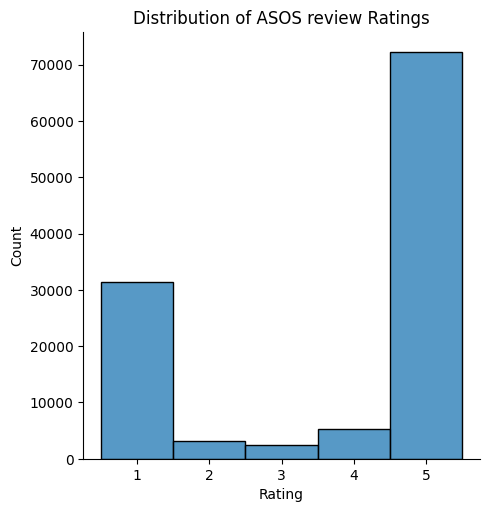

In [ ]:
print(f'No of reviews:{len(df)}')
# Dropping NA columns
df = df.dropna()
df = df.drop_duplicates(subset=['Review', 'Rating'])
print(f'No of reviews after dropping na and duplicates:{len(df)}')
print(f'Mean of ratings: {df.Rating.mean()}')
print(f'Median of ratings: {df.Rating.median()}')
sns.displot(df, x="Rating", discrete=True)

# Setting title
plt.title("Distribution of ASOS review Ratings")

# Displaying plot
plt.show()


In [ ]:
df

,Date,Rating,Title,Review
0,"May 15, 2018",5,Happily surprised! LOVE ASOS.,"I see a lot of negative reviews, however i wou..."
1,"May 15, 2018",1,They missed the estimated delivery date…,They missed the estimated delivery date by one...
2,"May 15, 2018",1,AVOID ASOS AT ALL COSTS,A month ago I placed an order for a few black ...
3,"May 15, 2018",4,great website but the app sometimes…,great website but the app sometimes isn't that...
4,"May 15, 2018",4,Great website,Been reading all those one star reviews and I ...
...,...,...,...,...
114708,"February 16, 2021",2,Ordine in ritardo causa corriere…,"Ordine in ritardo causa corriere inefficiente,..."
114709,"February 16, 2021",5,Really nice communication,"Really nice communication, couldn't solve my p..."
114710,"February 16, 2021",5,Had a problem with a return,Had a problem with a return and Joan resolved ...
114711,"February 16, 2021",2,Customer service is not putting…,Customer service is not putting customer first...


In [ ]:
# Making a new review metric for recomend/not recommend inspired by NPS score
df['Promoters'] = (df['Rating'] > 4).astype(int)



,Date,Rating,Title,Review,Promoters
0,"May 15, 2018",5,Happily surprised! LOVE ASOS.,"I see a lot of negative reviews, however i wou...",1
1,"May 15, 2018",1,They missed the estimated delivery date…,They missed the estimated delivery date by one...,0
2,"May 15, 2018",1,AVOID ASOS AT ALL COSTS,A month ago I placed an order for a few black ...,0
3,"May 15, 2018",4,great website but the app sometimes…,great website but the app sometimes isn't that...,0
4,"May 15, 2018",4,Great website,Been reading all those one star reviews and I ...,0


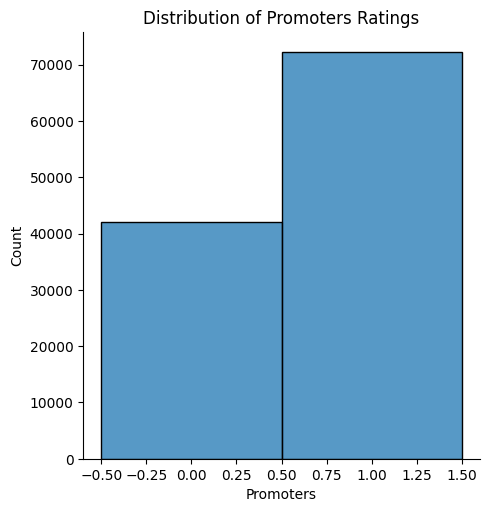

In [ ]:
# Printing distribution after converting ratings
sns.displot(df, x="Promoters", discrete=True)

# Setting title
plt.title("Distribution of Promoters Ratings")

# Displaying plot
plt.show()

In [ ]:
# Looking at values of classes, we see a slight imbalance.
# Using random sampling to achieve a 1=1 relationship  
class_0 = df[df['Promoters'] == 0]
class_1 = df[df['Promoters'] == 1]
class_1_under = class_1.sample(class_0['Promoters'].count())

# Confirming correct distribtuion
print(len(class_1_under))
print(len(class_0))

df_final = pd.concat([class_1_under, class_0],axis=0)

42107
42107


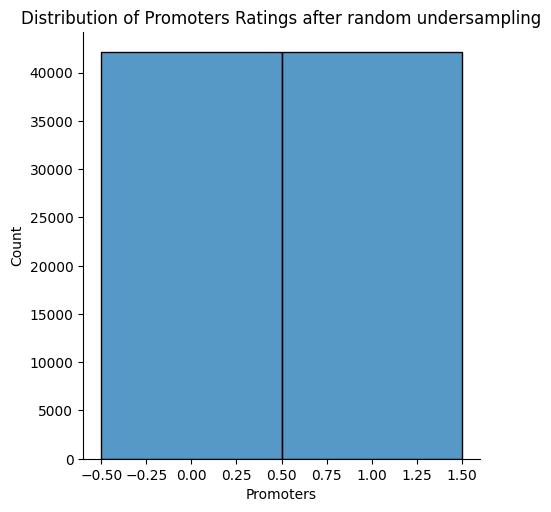

In [ ]:
# Printing distribution after converting ratings
sns.displot(df_final, x="Promoters", discrete=True)

# Setting title
plt.title("Distribution of Promoters Ratings after random undersampling")

# Displaying plot
plt.show()

## Preprocessing

Inspiration: https://medium.com/@annabiancajones/sentiment-analysis-of-reviews-text-pre-processing-6359343784fb 
Inspiration : https://github.com/sangha123/Intro-to-NLP-Topic-Modeling-and-Text-Categorization/blob/main/notebooks/topic_modeling_recipes_1.0.ipynb?fbclid=IwAR3xXwEhBQNVEp7kDE4HgNyxY58Osb79vT3Iux9oIxbz-3i_phiU-B7Rmcw

Inspiration: https://spacy.io/universe/project/spacymoji

### Steps: 
- Tokenization (done)
- Removing punctuations (done)
- Removing stopwords (done)
- Stemming  # Lemmization instead
- Lemmization (done)
- Normalization
  - Casing characters (done)
  - Writings numbers to text ( not done)
  - Negation handling (done) we just decided to keep not and not do much negation handling due to complicated issue and we decided that not keeps important meaning in short reviews. We are aware that this negation handling can cause ambiguity especially for longer sentences.
  - Handling smileys and emojis (done)




In [126]:
def preprocess_review(review):
    nlp = spacy.load('en_core_web_sm')
    nlp.add_pipe("emoji", first=True)


    # Convert text to lowercase
    review = review.lower()

    ### Tokenizing
    # Tokenize the review into sentences
    sentences = nltk.sent_tokenize(review)
    sentence_output = []
    all_words_output = []

    for sent in sentences:
        # Tokenize the sentence using spaCy
        doc = nlp(sent)
        # Tokenizing and preprocessing sentences using Spacy
        cleaned_words = [token.lemma_ for token in doc if 
                            not token._.is_emoji # Removing emojis
                            and (not token.is_stop or token.text.lower() == "not") # Removing non-'not' stop words
                            and token.is_alpha] # removing symbols 

    
        sentence_output.append(cleaned_words)
        for cleaned_word in cleaned_words:
          all_words_output.append(cleaned_word)

    return sentence_output, all_words_output

# Investigating sample.
review = """I did not make two orders on Asos on the 30th :-). I hate Asos 😋"""

sentences, all_words = preprocess_review(review)
for sentence in sentences:
    print(sentence)
print(f'All cleaned words in review: {len(all_words)}')


['not', 'order', 'asos']
['hate', 'asos']
All cleaned words in review: 5


In [133]:
df['tokenized_words'] = df['Review'].apply(lambda x: preprocess_review(x)[1])
df.to_csv('tokenized_data.csv', index=False)



KeyboardInterrupt: ignored